In [27]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [28]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [29]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [30]:
import random as rn
seed_num =42
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)

In [31]:
n_hours = 3
n_features = 43
'''
train_nun_23 = 2694
train_num_24 = 2789
train_num_25 = 2892
train_num_19 = 1934
'''
train_num_23 = 2694
train_num_24 = 2788
train_num_25 = 2891
train_num_19 = 1933
train_num_26= 3052

In [32]:
# from google.colab import drive
filename = 'j_rain_data.xlsx'

df = pd.read_excel(filename)

In [33]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()


df_matrix = df_matrix.astype('float32')
df_matrix = df_matrix[:,5:]

# scaler = MinMaxScaler(feature_range=(0, 1))
# df_matrix = scaler.fit_transform(df_matrix)
print(df_matrix)


# print(df_matrix.shape)
df_matrix1 = df_matrix[0:train_num_24, :] # 주 numpy
# df_matrix2 = df_matrix[train_num_24-4:train_num_25,5:] 
y = df_matrix[n_hours:train_num_24,42:43]
ans = df_matrix[train_num_23:train_num_24,5:6]

print(y.shape)
print(y)
print(df_matrix[0,0])

[[  6.4       7.        7.      ...   2.54    122.61    189.1    ]
 [  6.3       7.        8.      ...   2.53    122.6     216.95197]
 [  6.4       7.        9.      ...   2.53    122.59    251.42442]
 ...
 [  2.3689    1.        0.      ...   3.13    129.98          nan]
 [  2.3689    1.        0.      ...   3.11    129.99          nan]
 [  2.3689    1.        0.      ...   3.1     130.            nan]]
(2785, 1)
[[ 302.8122 ]
 [ 384.78342]
 [ 512.5012 ]
 ...
 [1348.523  ]
 [1300.583  ]
 [1253.6309 ]]
6.4


In [34]:
# print(df_matrix)
lag = series_to_supervised(df_matrix1, n_hours,1)

# print(lag)
print(lag.shape[1])
# for i in range(215,258):
#     lag.drop(lag.columns[[i]], axis = 1, inplace = True)


lag = lag.values

tmp = lag.shape[1]

lag = lag[:,0:tmp-1]
print(lag.shape)
lag


172
(2785, 171)


array([[  6.4   ,   7.    ,   7.    , ...,  14.    ,   2.53  , 122.585 ],
       [  6.3   ,   7.    ,   8.    , ...,  16.    ,   2.53  , 122.575 ],
       [  6.4   ,   7.    ,   9.    , ...,  17.    ,   2.53  , 122.565 ],
       ...,
       [171.2724, 232.    , 141.    , ...,  73.    ,   4.76  , 122.94  ],
       [166.8818, 232.    , 141.    , ...,  72.    ,   4.68  , 123.135 ],
       [159.0198, 230.    , 136.    , ...,  72.    ,   4.62  , 123.32  ]],
      dtype=float32)

In [35]:
# n_train_hours = train_num_19
train_X = lag
# test_X = lag[n_train_hours:, :]
# train_y = y[:n_train_hours, :]
# test_y = y[n_train_hours:, :]

In [36]:
n_obs = n_hours * (n_features)
# train_X, train_y = train[:, :n_obs], train[:, -130]
print('train_X: ',train_X)
# print('train_y: ',train_y)
# test_X, test_y = test[:, :n_obs], test[:, -130]
#print('test_y: ',test_y)
# print(train_X.shape, len(train_X), test_X.shape)
garo = train_X.shape[1]
print(garo)
# reshape input to be 3D [samples, timesteps, features]
print(train_X.shape,y.shape)
train_X = train_X.reshape((train_X.shape[0],1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],1, test_X.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X:  [[  6.4      7.       7.     ...  14.       2.53   122.585 ]
 [  6.3      7.       8.     ...  16.       2.53   122.575 ]
 [  6.4      7.       9.     ...  17.       2.53   122.565 ]
 ...
 [171.2724 232.     141.     ...  73.       4.76   122.94  ]
 [166.8818 232.     141.     ...  72.       4.68   123.135 ]
 [159.0198 230.     136.     ...  72.       4.62   123.32  ]]
171
(2785, 171) (2785, 1)


In [37]:
#print('test_y: ',test_y)

Text(0, 0.5, 'AMOUNT')

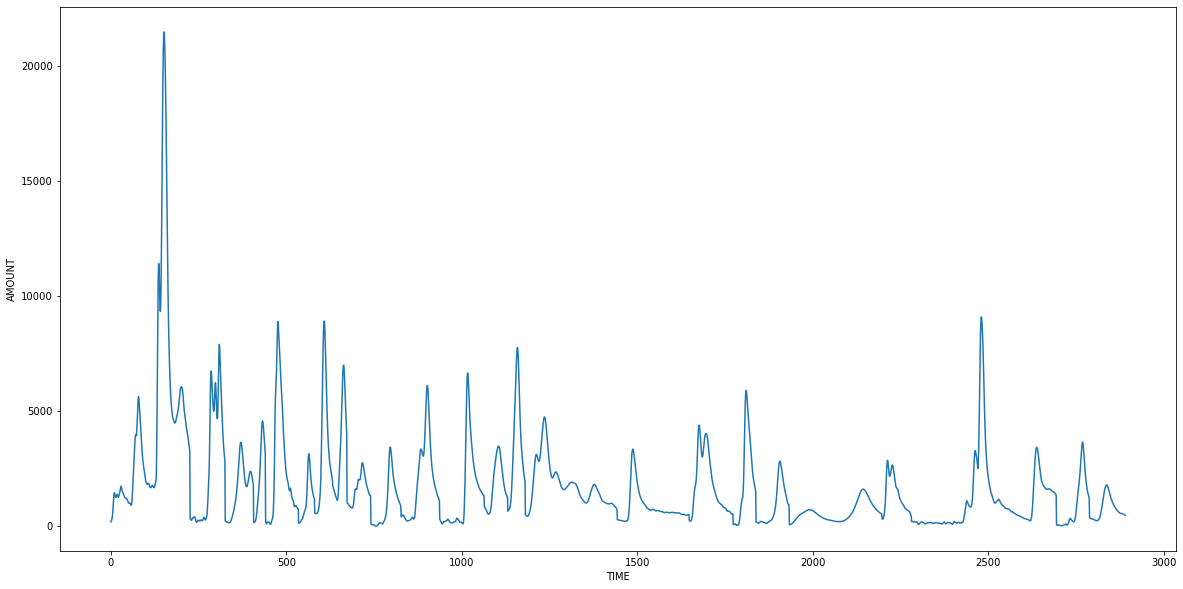

In [38]:
# print(df_matrix[train_num_25-1][42])
plt.figure(figsize=(20, 10))
# sns.lineplot(y=df_scaled['유입량'], x=df['일자'])
# plt.xlabel('TIME')
# plt.ylabel('AMOUNT')
plt.plot(df['유입량'])
plt.xlabel('TIME')
plt.ylabel('AMOUNT')

In [43]:
one = df_matrix[train_num_24:train_num_25,0]
one

array([0.00000e+00, 0.00000e+00, 1.77000e-02, 1.06310e+00, 2.92410e+00,
       3.37890e+00, 3.80940e+00, 3.85360e+00, 3.85360e+00, 3.85360e+00,
       3.85360e+00, 3.85360e+00, 3.85360e+00, 3.85360e+00, 3.89490e+00,
       4.46730e+00, 5.54690e+00, 6.03330e+00, 6.32980e+00, 6.37690e+00,
       6.40620e+00, 6.40620e+00, 6.40620e+00, 6.57350e+00, 6.80830e+00,
       7.71000e+00, 8.66450e+00, 1.10720e+01, 1.45112e+01, 1.61824e+01,
       1.62263e+01, 1.65255e+01, 1.66739e+01, 1.66739e+01, 1.67977e+01,
       1.72907e+01, 1.79087e+01, 2.10407e+01, 2.68530e+01, 3.25293e+01,
       4.62586e+01, 6.07836e+01, 6.49333e+01, 6.56568e+01, 6.57581e+01,
       6.62908e+01, 6.69280e+01, 6.71688e+01, 6.72514e+01, 6.72514e+01,
       6.73056e+01, 6.73056e+01, 6.73056e+01, 6.73056e+01, 6.73056e+01,
       6.73056e+01, 6.73374e+01, 6.73374e+01, 6.73374e+01, 6.73374e+01,
       6.73197e+01, 6.62743e+01, 6.44133e+01, 6.39585e+01, 6.35280e+01,
       6.36653e+01, 6.36653e+01, 6.36653e+01, 6.36653e+01, 6.366

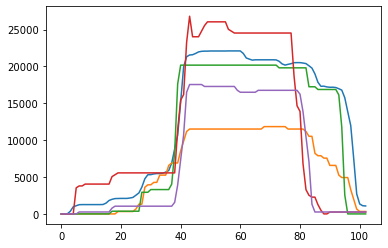

In [25]:
one = df_matrix[train_num_24:train_num_25,0]
two = df_matrix[train_num_24:train_num_25,1]
three = df_matrix[train_num_24:train_num_25,2]
four = df_matrix[train_num_24:train_num_25,3]
five = df_matrix[train_num_24:train_num_25,4]

plt.plot(one)
plt.plot(two)
plt.plot(three)
plt.plot(four)
plt.plot(five)
# plt.plot(real)
plt.show()

In [26]:
train_num_24

2788

In [20]:
# import os
# from keras import optimizers

print(train_num_24,train_num_25)
for i in range(train_num_24,train_num_25):
  print(i)
  model = Sequential()
  model.add(LSTM(20, input_shape=(train_X.shape[1],train_X.shape[2]), activation='tanh', return_sequences=False))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(lr=0.0001)

  model.compile(loss='mean_squared_error', optimizer='adam')
#early_stop = EarlyStopping(monitor='val_loss', patience=3)
#model_path = 'model'
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

  history = model.fit(train_X, y, 
                                    epochs=1, 
                                    batch_size=32,
                                    # validation_data=(test_X, test_y), 
                                    )

  
  tmp = df_matrix[i-3:i+1,:]
  tmp=tmp.reshape(1,172)
  
  # print(tmp.shape)
  tmp = tmp[:,:-1]
  # print(tmp)
  tmp = tmp.reshape((tmp.shape[0],1,tmp.shape[1]))
  # print(tmp)
  ans = model.predict(tmp)
  df_matrix[i][42]=ans
  # print(ans)
  y = np.concatenate((y,ans),axis =0) #정답 붙이기


  # print(train_X.shape,tmp.shape)
  train_X = np.concatenate((train_X,tmp),axis =0)
  # print(train_X)
  # print(y)



2788 2891
2788
91/91 [==============================] - 0s 3ms/step - loss: 0.0038
2789
91/91 [==============================] - 0s 2ms/step - loss: 0.0058
2790
91/91 [==============================] - 0s 2ms/step - loss: 0.0024
2791
91/91 [==============================] - 0s 2ms/step - loss: 0.0068
2792
91/91 [==============================] - 0s 3ms/step - loss: 0.0029
2793
91/91 [==============================] - 0s 2ms/step - loss: 0.0042
2794
91/91 [==============================] - 0s 3ms/step - loss: 0.0041
2795
91/91 [==============================] - 0s 2ms/step - loss: 0.0040
2796
91/91 [==============================] - 0s 3ms/step - loss: 0.0067
2797
91/91 [==============================] - 0s 3ms/step - loss: 0.0053
2798
91/91 [==============================] - 0s 2ms/step - loss: 0.0026
2799
91/91 [==============================] - 0s 2ms/step - loss: 0.0052
2800
91/91 [==============================] - 0s 2ms/step - loss: 0.0038
2801
91/91 [=============================

In [21]:
df_matrix =scaler.inverse_transform(df_matrix)

real = df_matrix[train_num_24:train_num_25,42]
print(real)

df_tmp = df.to_numpy()
df_tmp = df_tmp.astype('float32')

df_tmp = df_tmp[:,5:]
df_tmp = df_tmp[train_num_24:train_num_25,42]

[ 11067.444      4417.2075    -3888.3098      127.68856    3973.314
   1770.9862    -1969.2738     2076.0266     4674.5366    -1473.3337
   -749.8112    -1022.811     -3354.3933    -1796.226      -246.46857
  -4208.1025    -4967.173     -6650.753     -2137.5095    -4903.3154
  -3311.3428    -7474.3604    -4985.259     -2127.5876    -2666.6008
    801.37085   -2270.7246    -5746.2544    -3212.6697     -167.83002
  -3937.18      -1475.9879    -4368.9463    -3893.415       539.4898
  -3740.4424     7930.3096    -4680.0586    -1224.5068    -1004.1843
   1865.9517    -2635.8633     6148.9805     2256.6084    -4065.5881
  -5801.43       5976.5312     2766.5938    -3414.7263     6690.3823
  -2012.7189     2193.7073     -129.14944    1645.6945     -979.97797
   3255.4841    -2654.0007      215.34267   -1919.6012     3983.7458
   -777.3599     7916.5376     -583.8506    -3600.6553    -1688.0431
    979.77954   -1711.9215     -856.6924     1219.6992      635.7837
   1193.493      9692.34        

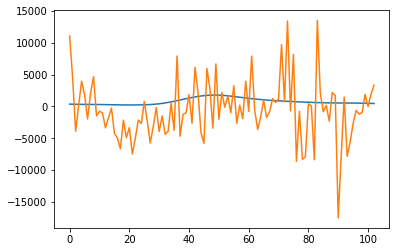

In [22]:
plt.plot(df_tmp)
plt.plot(real)
plt.show()

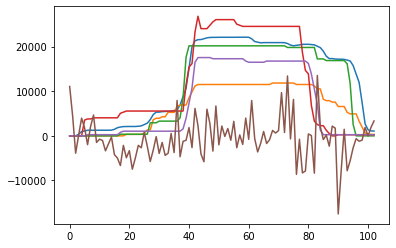

In [23]:
one = df_matrix[train_num_24:train_num_25,0]
two = df_matrix[train_num_24:train_num_25,1]
three = df_matrix[train_num_24:train_num_25,2]
four = df_matrix[train_num_24:train_num_25,3]
five = df_matrix[train_num_24:train_num_25,4]

plt.plot(one)
plt.plot(two)
plt.plot(three)
plt.plot(four)
plt.plot(five)
plt.plot(real)
plt.show()

In [24]:
from openpyxl import Workbook

write_wb = Workbook()
write_ws = write_wb.create_sheet("결과")

write_ws = write_wb.active
real= real.tolist()
# print(len(real))
for i in range(len(real)):
  write_ws.cell(i+1,1,real[i])
write_wb.save('테스트_결과100.xlsx')

In [18]:

#여기까지임

In [19]:
yhat = model.predict(test_X)


inv_yhat = df_matrix
a=0
for i in range(train_num_19+3,train_num_24):
  df_matrix[i][42]=yhat[a]
  a+=1

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[train_num_19+3:train_num_24,42:43]
print(inv_yhat)


NameError: name 'test_X' is not defined

In [ ]:
np.set_printoptions(suppress=True)

print(inv_yhat)
print(inv_yhat.shape)

In [ ]:

inv_y = scaler.inverse_transform(df_matrix)
inv_y = inv_y[train_num_19+3:train_num_24,42:43]


print(inv_y)
print(inv_y.shape)

In [ ]:
print(inv_yhat[0])

In [ ]:
plt.plot(inv_yhat)
plt.plot(inv_y)
plt.show()

In [ ]:
RMSE = mean_squared_error(inv_yhat,inv_y)**0.5
RMSE

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_y, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()